# Quantum Fourier Transform

In [2]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

## Background QFT info

### Introducting to Fourier Transforms

It is very common in many different problems in various fields to "transform" the problem into some other problem with a known solution. Fortunately, some of these transformations can be computed with much greater speed on a quantum computer than a classical one. The transform we will be focusing on is called the discrete Fourier transform (DFT). Classically, the DFT takes a vector of complex numbers $x_j = (x_0,\dots,x_{N-1})$ with finite length $N$ as input returing an output of the vector $y_k = (y_0,\dots,y_{N-1})$. Here, $N = 2^m$ where $m$ is the number of qubits in the system. The returned vector $y_k$ is also complex and is defined by

$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$

where $\omega_N^{jk} = e^{2\pi i\frac{jk}{N}}$ which gives us

$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_je^{2\pi i\frac{jk}{N}}$$

Another way to interpret this formula is as a matrix and vector. For example, by expanding $y_k$, we can see

$$y_0 = \frac{1}{\sqrt{N}}(x_0\omega^{0\cdot 0} + x_1\omega^{1\cdot 0} + x_2\omega^{2\cdot 0} + \dots + x_{N-1}\omega^{(N-1)\cdot 0}) = \frac{1}{\sqrt{N}}(x_0 + x_1 + x_2 + \dots + x_{N-1})$$

$$y_1 = \frac{1}{\sqrt{N}}(x_0\omega^{0\cdot 1} + x_1\omega^{1\cdot 1} + x_2\omega^{2\cdot 1} + \dots + x_{N-1}\omega^{(N-1)\cdot 1}) = \frac{1}{\sqrt{N}}(x_0 + x_1\omega + x_2\omega^2 + \dots + x_{N-1}\omega^{N-1})$$

$$y_2 = \frac{1}{\sqrt{N}}(x_0\omega^{0\cdot 2} + x_1\omega^{1\cdot 2} + x_2\omega^{2\cdot 2} + \dots + x_{N-1}\omega^{(N-1)\cdot 2}) = \frac{1}{\sqrt{N}}(x_0 + x_1\omega^2 + x_2\omega^4 + \dots + x_{N-1}\omega^{2(N-1)})$$

$$\vdots$$

$$y_{N-1} = \frac{1}{\sqrt{N}}(x_0\omega^{0\cdot (N-1)} + x_1\omega^{1\cdot (N-1)} + x_2\omega^{2\cdot (N-1)} + \dots + x_{N-1}\omega^{(N-1)\cdot (N-1)}) = \frac{1}{\sqrt{N}}(x_0 + x_1\omega^{(N-1)} + x_2\omega^{2(N-1)} + \dots + x_{N-1}\omega^{(N-1)^2})$$

By simply using the coefficients of each equation, we can construct the following matrix-vector multiplication:

$$\begin{pmatrix}y_0\\ y_1\\ y_2\\ \vdots \\ y_{N-1} \end{pmatrix} = \frac{1}{\sqrt{N}}\begin{pmatrix}1 & 1 & 1 & \dots & 1 \\ 1 & \omega & \omega ^2 & \dots & \omega ^{N-1} \\ 1 & \omega ^2 & \omega ^4 & \dots & \omega^{2(N-1)} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & \omega ^{N-1} & \omega ^{2(N-1)} & \dots & \omega ^{(N-1)^2} \end{pmatrix} \begin{pmatrix}x_0\\ x_1\\ x_2\\ \vdots \\ x_{N-1} \end{pmatrix}$$

This notation helps us clearly see how the DFT is effectively a matrix transforming a vector of amplitudes.

As it turns out, this $N\times N$ matrix is unitary, thus making it a valid quantum operation. This is the quantum Fourier transform (QFT) which is functionally the exact same transformation as the DFT, though with a bit different notation. The QFT acts on an orthonormal basis of a quantum state $|\Psi\rangle = \sum_{j=0}^{N-1}x_j|j\rangle = x_0|0\rangle,\dots,x_{N-1}|N-1\rangle$ outputing a different quantum state $|\Phi\rangle = \sum_{k=0}^{N-1}y_k|k\rangle = y_0|0\rangle,\dots,y_{N-1}|N-1\rangle$ defined by the formula

$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk} = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_je^{2\pi i\frac{jk}{N}}$$

This is more commonly expressed as the map

$$|j\rangle \mapsto \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}e^{2\pi i\frac{jk}{N}}|k\rangle$$

or the unitary matrix sum

$$U_{QFT} = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}\sum_{k=0}^{N-1}e^{2\pi i\frac{jk}{N}}|k\rangle \langle j|$$

For example, if we have a normalized quantum state

$$|\Psi\rangle = \begin{pmatrix}x_0 \\ x_1 \\ \vdots \\ x_{N-1}\end{pmatrix} = x_0|0\rangle+\dots+x_{N-1}|N-1\rangle$$

then applying the QFT to this state will result in another normalized quantum state

$$|\Phi\rangle = \begin{pmatrix}y_0 \\ y_1 \\ \vdots \\ y_{N-1}\end{pmatrix} = y_0|0\rangle+\dots+y_{N-1}|N-1\rangle$$

where we call this the quantum Fourier transform of $|\Psi\rangle$. Therefore we can say $|\Psi\rangle$ maps to $|\Phi\rangle$ in the following way:

$$|\Psi\rangle = \sum_{j=0}^{N-1}x_j|j\rangle \mapsto |\Phi\rangle = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}\sum_{j=0}^{N-1}x_je^{2\pi i\frac{jk}{N}}|k\rangle = \sum_{k=0}^{N-1}y_k|k\rangle$$

In simple terms, the QFT transforms between two bases: the computational basis ($Z$ basis), and the Fourier basis. Let's look at the QFT for a few different values of $N$ to see what it means. By defining $\omega_N = e^{\frac{2\pi i}{N}} = \cos(\frac{2\pi}{N}) + i \sin(\frac{2\pi}{N})$ we can compute the QFT for any number of qubits:

$$\text{QFT}_N = \frac{1}{\sqrt{N}}\begin{pmatrix}1 & 1 & 1 & \dots & 1 \\ 1 & \omega & \omega ^2 & \dots & \omega ^{N-1} \\ 1 & \omega ^2 & \omega ^4 & \dots & \omega^{2(N-1)} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & \omega ^{N-1} & \omega ^{2(N-1)} & \dots & \omega ^{(N-1)^2} \end{pmatrix}$$

$$\text{QFT}_1 = \frac{1}{\sqrt{N}}\begin{pmatrix}1 \end{pmatrix} = \frac{1}{\sqrt{1}}\begin{pmatrix}1 \end{pmatrix} = \begin{pmatrix}1 \end{pmatrix}$$

$$\text{QFT}_2 = \frac{1}{\sqrt{N}}\begin{pmatrix}1 & 1 \\ 1 & \omega \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & e^{\frac{2\pi i}{N}} \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & \cos(\frac{2\pi}{2}) + i \sin(\frac{2\pi}{2}) \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & \cos(\pi) + i \sin(\pi) \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & -1 \end{pmatrix} = H$$

$$\text{QFT}_3 = \frac{1}{\sqrt{N}}\begin{pmatrix}1 & 1 & 1 \\ 1 & \omega & \omega ^2 \\ 1 & \omega ^2 & \omega ^4 \end{pmatrix} = \frac{1}{\sqrt{3}}\begin{pmatrix}1 & 1 & 1 \\ 1 &  e^{\frac{2\pi i}{N}} &  e^{\frac{4\pi i}{N}} \\ 1 &  e^{\frac{4\pi i}{N}} &  e^{\frac{8\pi i}{N}} \end{pmatrix} = \frac{1}{\sqrt{3}}\begin{pmatrix}1 & 1 & 1 \\ 1 &  \cos(\frac{2\pi}{3}) + i \sin(\frac{2\pi}{3}) &  \cos(\frac{4\pi}{3}) + i \sin(\frac{4\pi}{3}) \\ 1 & \cos(\frac{4\pi}{3}) + i \sin(\frac{4\pi}{3}) &  \cos(\frac{8\pi}{3}) + i \sin(\frac{8\pi}{3}) \end{pmatrix} = \frac{1}{\sqrt{3}}\begin{pmatrix}1 & 1 & 1 \\ 1 & \frac{-1 + i\sqrt{3}}{2} & \frac{-1 - i\sqrt{3}}{2} \\ 1 & \frac{-1 - i\sqrt{3}}{2} &  \frac{-1 + i\sqrt{3}}{2} \end{pmatrix}$$

bloch sphere rotation in fourier vs computational

fourier summation derivation

unitary matrix form of fourier

Rotation gate

1-qubit qft (walk through circuit math)

## Algorithm

$R(\theta) = \begin{pmatrix}1&0\\0&e^{i\theta}\end{pmatrix}$

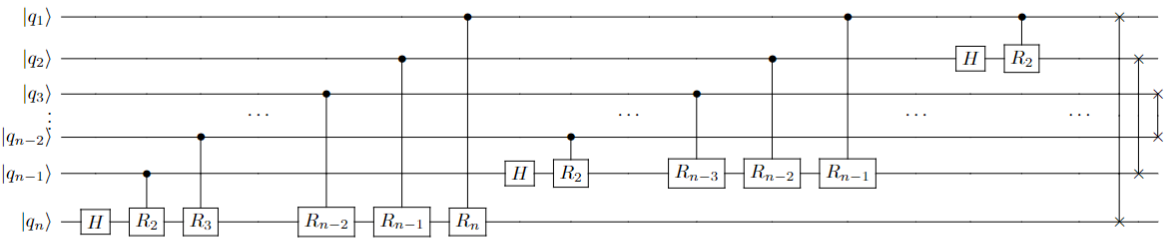

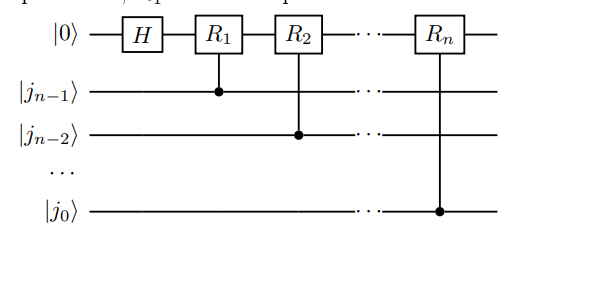

$$\text{Fig. }3.1:\text{ QFT Circuit }$$

### Proof
$$ U_{FT}|j\rangle = \frac{1}{\sqrt{N}}\sum_{k \in N}e^{i2\pi \frac{kj}{N}}|k\rangle$$
$$ U_{FT}^\dagger|j\rangle = \frac{1}{\sqrt{N}}\sum_{k \in N}e^{-i2\pi \frac{kj}{N}}|k\rangle$$
Where k and j are binary numbers
$k = (k_{n-1} \cdots k_0.), j = (j_{n-1} \cdots j_0.)$

$$\frac{kj}{N} = k_0\frac{j}{2^n} +k_1\frac{j}{2^{n-1}} + \cdots + k_n\frac{j}{2} = k_0(j_n.j_{n-1} \cdots j_0) +k_1(j_nj_{n-1}.j_{n-2} \cdots j_0) + \cdots + k_n(j_nj_{n-1}j_{n-2}.j_{n-3} \cdots j_0)$$ 
show general circuit as function

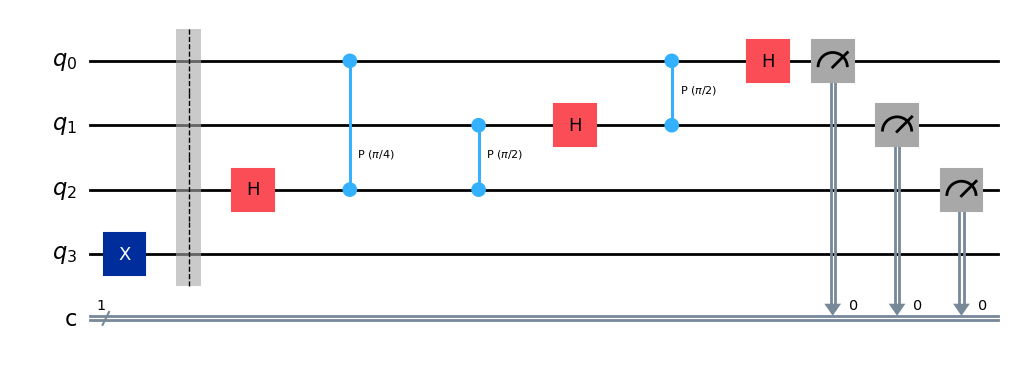

In [24]:
qc = QuantumCircuit(4,1)
qc.x(3)
qc.barrier()
qc.h(2)
qc.cp(pi/4,0,2)
qc.cp(pi/2,1,2)
qc.h(1)
qc.cp(pi/2,0,1)
qc.h(0)
#qc.swap(0,2)
qc.measure(0,0)
qc.measure(1,0)
qc.measure(2,0)
qc.draw('mpl')

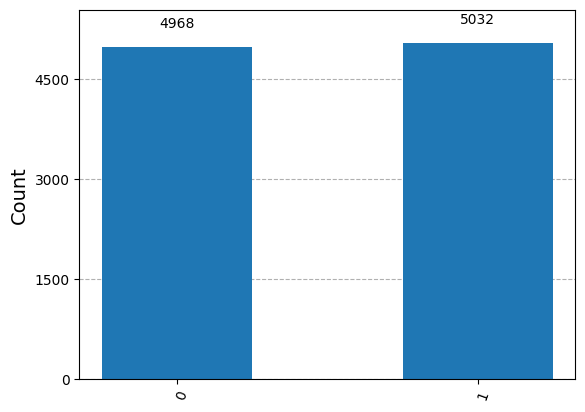

In [22]:
backend = BasicSimulator()

num_of_shots = 10000

result = backend.run(qc, shots=num_of_shots).result()   
counts = result.get_counts()                    
plot_histogram(counts)

### Verfication